# 0. Imports

In [93]:
import pandas as pd
import psycopg2 as pg
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import credentials

## 0.1. Helper Function

In [94]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    
    plt.rcParams['figure.figsize'] = [25,8]
    plt.rcParams['font.size'] = 24
    sns.set()
    sns.set_theme()
    sns.set_color_codes()

In [95]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Load Data

In [96]:
sql_query = """
select 
  u.id,
  u.gender,
  u.age,
  u.region_code,
  u.policy_sales_channel,
  i.previously_insured,
  i.annual_premium,
  i.vintage,
  v.driving_license,
  v.vehicle_age,
  v.vehicle_damage,
  i.response
from pa004.users u 
inner join pa004.insurance i on u.id = i.id 
inner join pa004.vehicle v on u.id = v.id
where u.id between 1 and 381109 -- limit id to guarantee the same data is fetched
"""

conn = pg.connect(
    user=credentials.USER,
    password=credentials.PWD,
    host=credentials.HOST,
    port=credentials.PORT,
    database=credentials.DB
)

df_raw = pd.read_sql(sql_query, conn)

# 2. Data Description

In [97]:
df_dd = df_raw.copy()

## 2.1. Data Dimension

In [98]:
print(f'Number of rows: {df_dd.shape[0]}')
print(f'Number of columns: {df_dd.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 2.2. Data Types

In [99]:
df_dd.sample()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
227525,292670,Male,34,14.0,26.0,0,18653.0,151,1,1-2 Year,Yes,1


In [100]:
df_dd.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

In [101]:
# change the feature region_code to int
df_dd['region_code'] = df_dd['region_code'].astype(int)

# change the feature policy_sales_channel to int
df_dd['policy_sales_channel'] = df_dd['policy_sales_channel'].astype(int)

df_dd.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## 2.3. Check NAs

In [102]:
df_dd.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

No NAs found, no further action needed.

## 2.4. Descriptive Statistics

In [103]:
# lets separate the features in numerical and categorical
num_features = ['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']
cat_features = ['gender', 'previously_insured', 'driving_license', 'vehicle_age', 'vehicle_damage', 'response'] # include response to make some analysis

### 2.4.1. Numerical Features

In [104]:
# Central Tendency
ct1 = df_dd[num_features].apply(np.mean)
ct2 = df_dd[num_features].apply(np.median)

# Dispersion
d1 = df_dd[num_features].apply(np.std)
d2 = df_dd[num_features].min()
d3 = df_dd[num_features].max()
d4 = df_dd[num_features].apply(lambda x: x.max() - x.min())
d5 = df_dd[num_features].skew()
d6 = df_dd[num_features].kurtosis()

In [105]:
df_metrics = pd.DataFrame([ct1, ct2, d1, d2, d3, d4, d5, d6]).T.reset_index()
df_metrics.columns = ['feature', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [106]:
df_metrics

,feature,mean,median,std,min,max,range,skew,kurtosis
0,age,38.822584,36.0,15.511591,20.0,85.0,65.0,0.672539,-0.565655
1,region_code,26.388807,28.0,13.229871,0.0,52.0,52.0,-0.115266,-0.867857
2,policy_sales_channel,112.034295,133.0,54.203924,1.0,163.0,162.0,-0.900008,-0.970810
3,annual_premium,30564.389581,31669.0,17213.132474,2630.0,540165.0,537535.0,1.766087,34.004569
4,vintage,154.347397,154.0,83.671194,10.0,299.0,289.0,0.003030,-1.200688


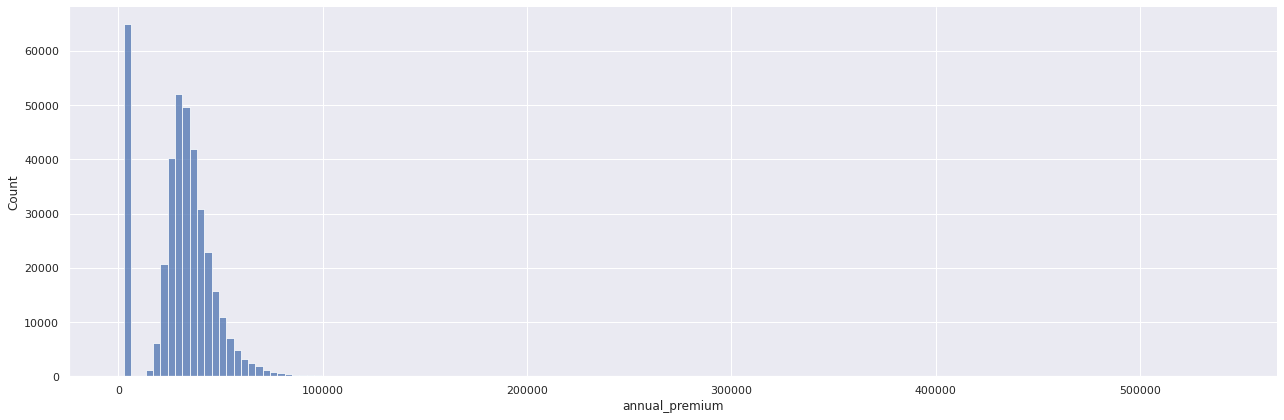

In [107]:
sns.displot(df_dd['annual_premium'], height=6, aspect=3, bins=150);

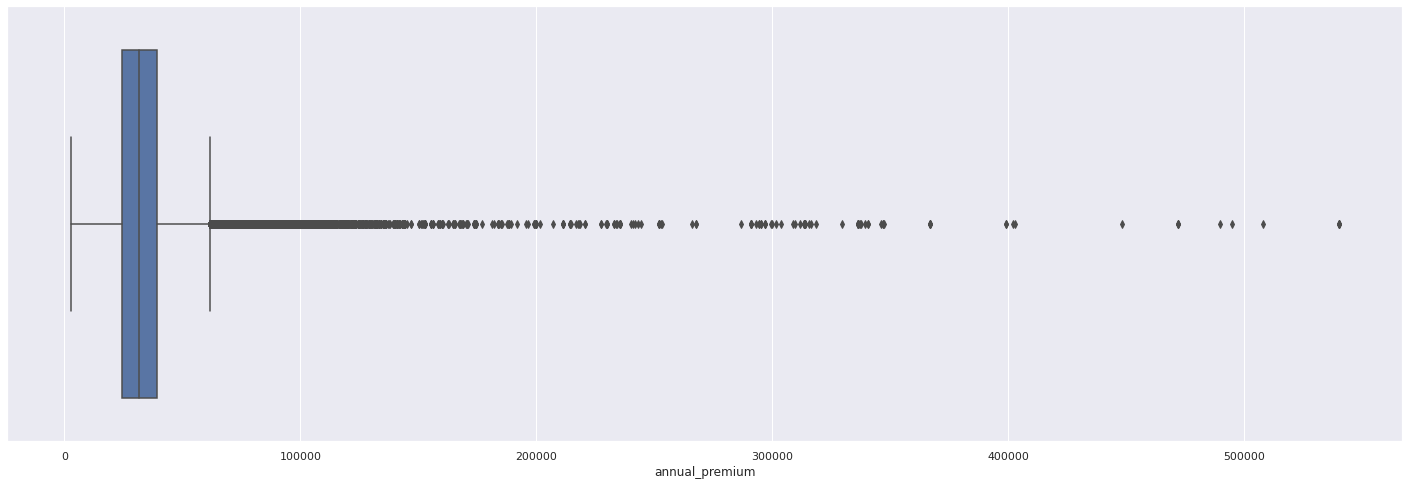

In [108]:
sns.boxplot(x = 'annual_premium', data=df_dd);

### 2.4.2. Categorical Features

In [109]:
df_dd[cat_features].apply(lambda x: x.unique().shape[0])

gender                2
previously_insured    2
driving_license       2
vehicle_age           3
vehicle_damage        2
response              2
dtype: int64

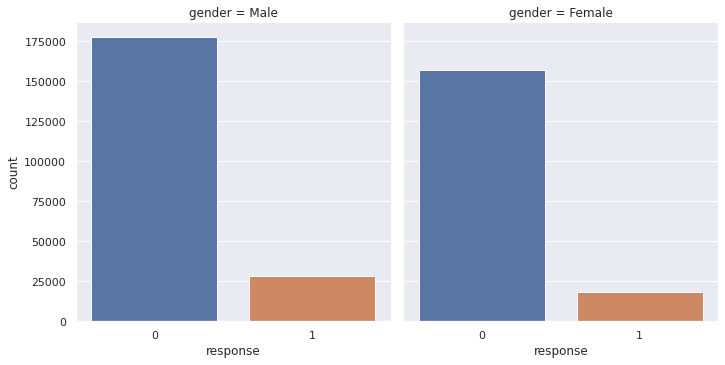

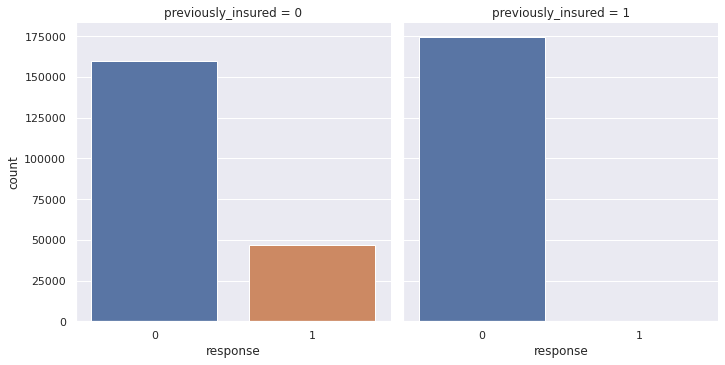

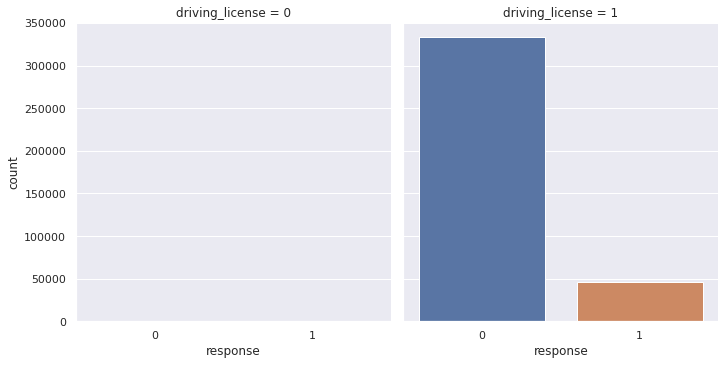

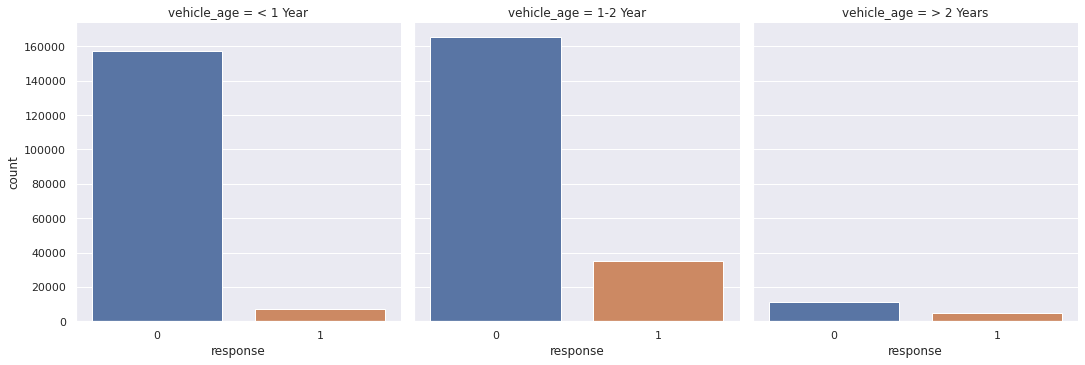

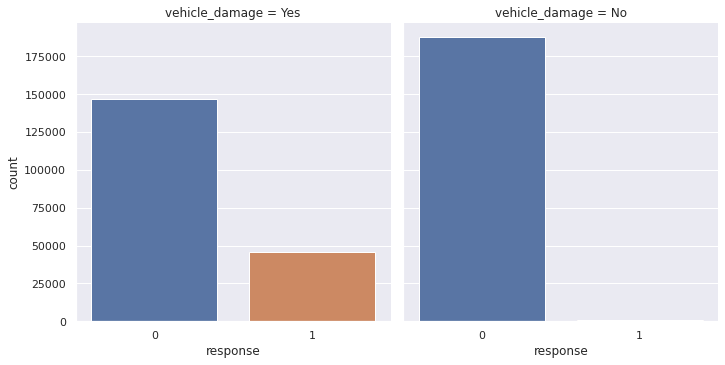

In [110]:
sns.catplot(x='response', col='gender', kind='count', data=df_dd[cat_features])
sns.catplot(x='response', col='previously_insured', kind='count', data=df_dd[cat_features])
sns.catplot(x='response', col='driving_license', kind='count', data=df_dd[cat_features])
sns.catplot(x='response', col='vehicle_age', kind='count', data=df_dd[cat_features]);
sns.catplot(x='response', col='vehicle_damage', kind='count', data=df_dd[cat_features]);

### 2.4.3. Response Variable

In [111]:
df_dd['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

We have an unbalanced problem, because only 12% of our samples have the response label = 1

# 3. Feature Engineering

In [112]:
df_fe = df_dd.copy()

In [113]:
df_fe.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11,152,0,23367.0,249,1,< 1 Year,Yes,0
1,13,Female,41,15,14,1,31409.0,221,1,1-2 Year,No,0
2,18,Female,25,35,152,1,46622.0,299,1,< 1 Year,No,0
3,31,Female,26,8,160,0,2630.0,136,1,< 1 Year,No,0
4,39,Male,45,8,124,0,42297.0,264,1,1-2 Year,Yes,0


No new feature for now

# 4. Exploratory Data Analysis

In [114]:
df_eda = df_fe.copy()

## 4.1. Univariate Analysis

### 4.1.1. Numerical Features

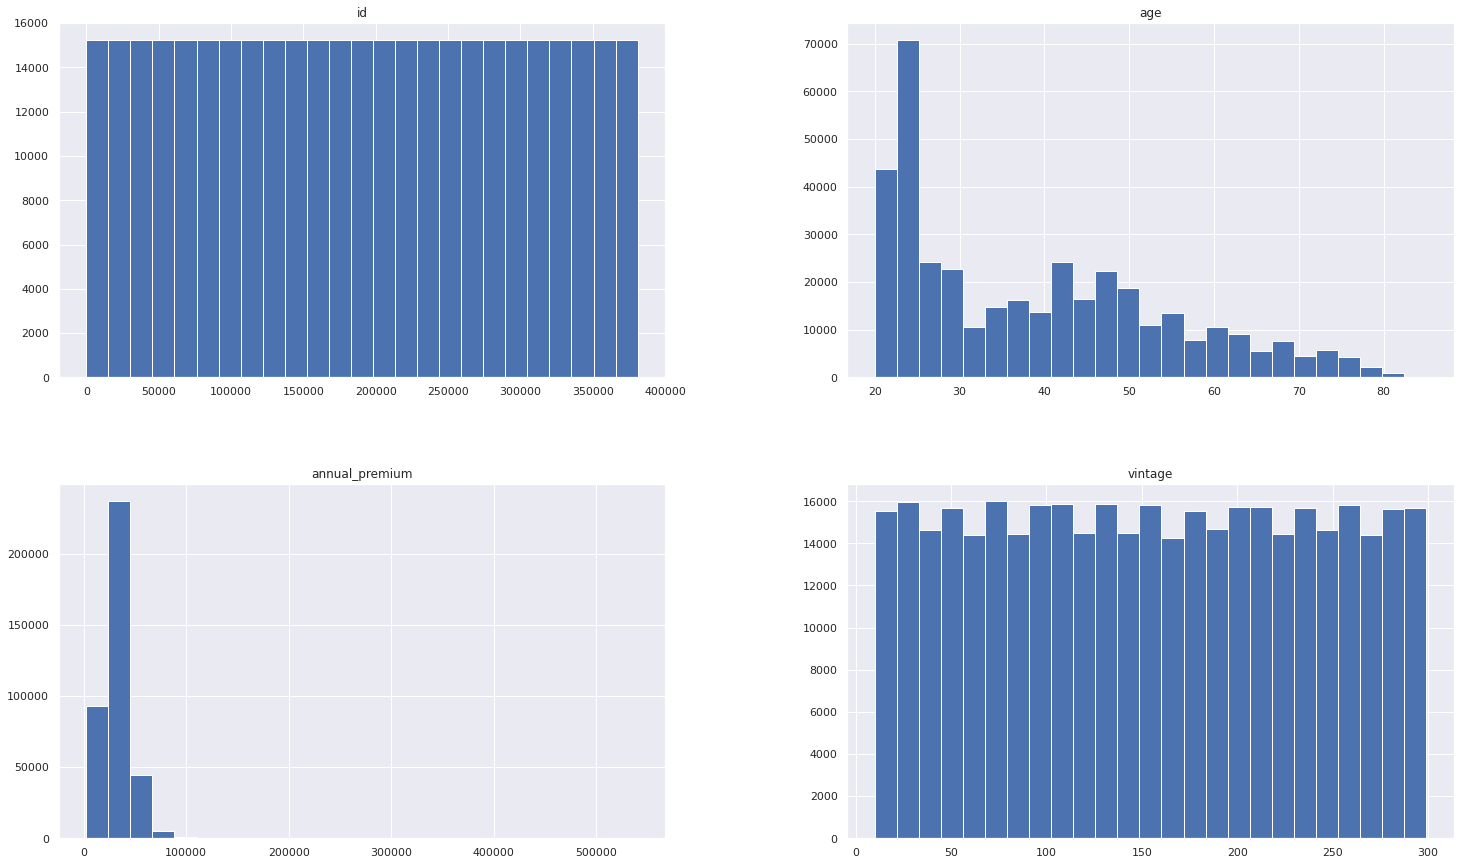

In [115]:
df_eda[['id', 'age', 'annual_premium', 'vintage']].hist(bins=25, figsize=(25,15));

By looking at the numerical features alone, we can observe:
- The most commom age between our customers is around 20-25 yo, although, we have a good concentration of customers between 30 and 50 yo.
- The majority of our customers have annual premiums lower than aprox. 50k.
- Our base of clients is well distributed when looking at vintage.

### 4.1.2. Categorical Features

In [116]:
df_eda.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11,152,0,23367.0,249,1,< 1 Year,Yes,0
1,13,Female,41,15,14,1,31409.0,221,1,1-2 Year,No,0
2,18,Female,25,35,152,1,46622.0,299,1,< 1 Year,No,0
3,31,Female,26,8,160,0,2630.0,136,1,< 1 Year,No,0
4,39,Male,45,8,124,0,42297.0,264,1,1-2 Year,Yes,0


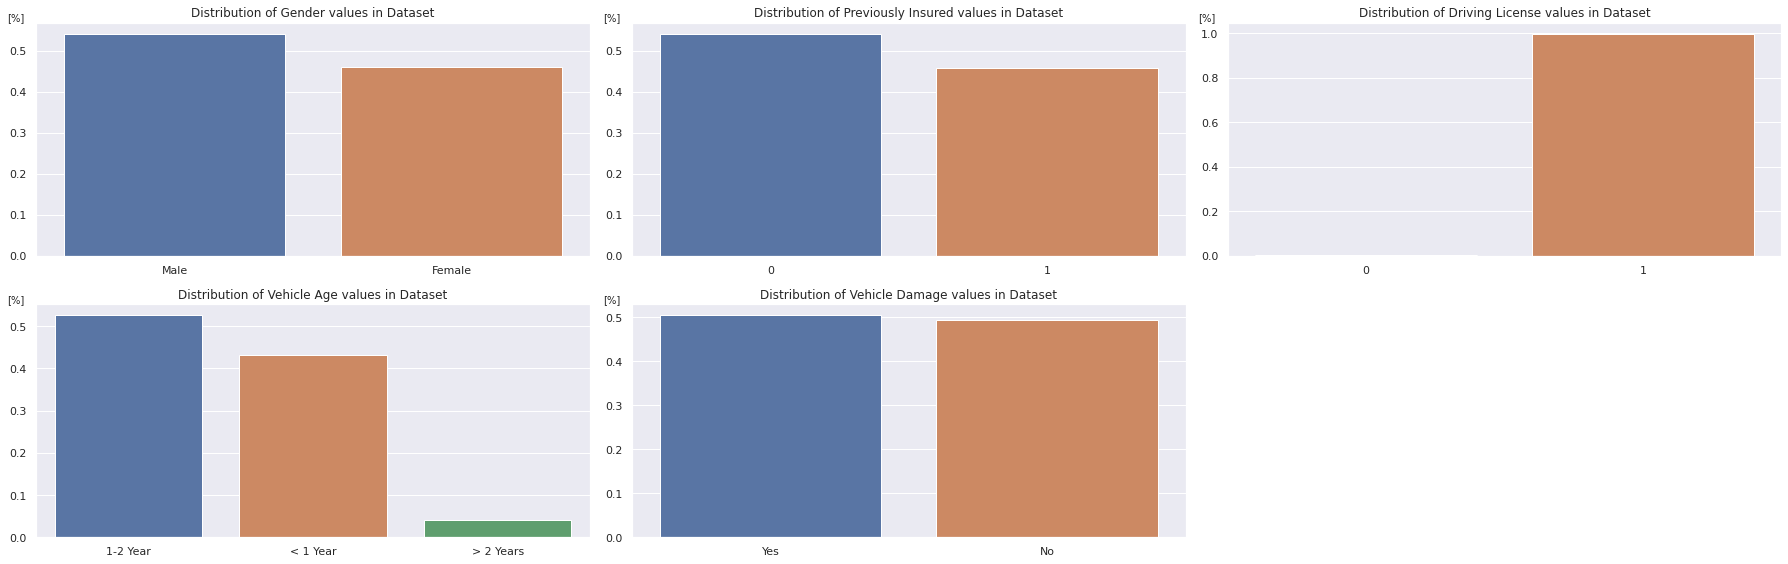

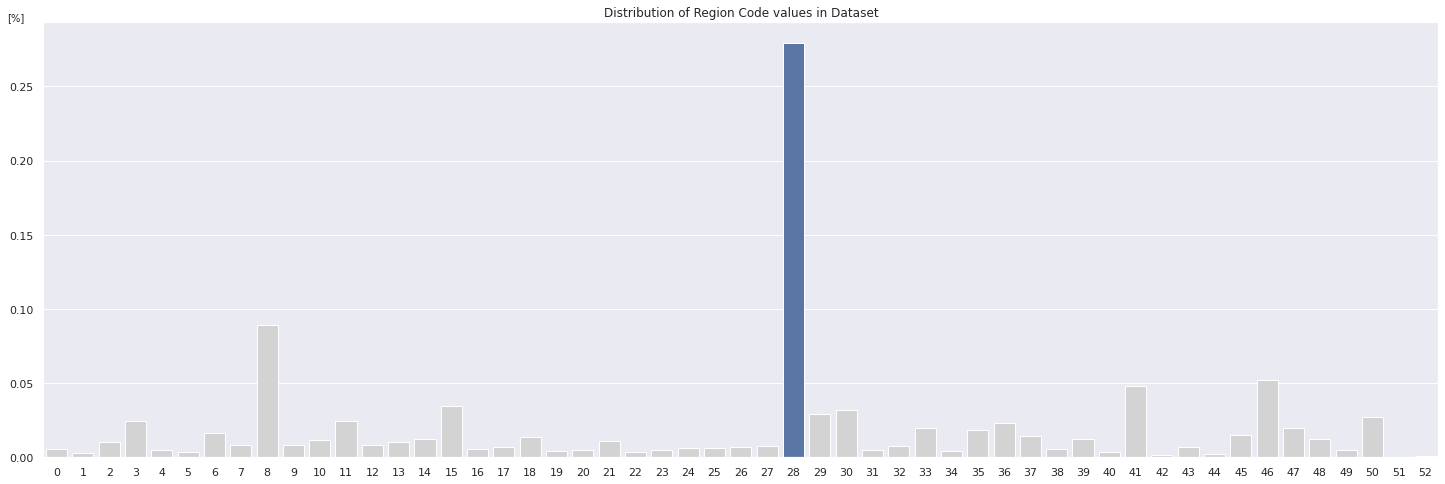

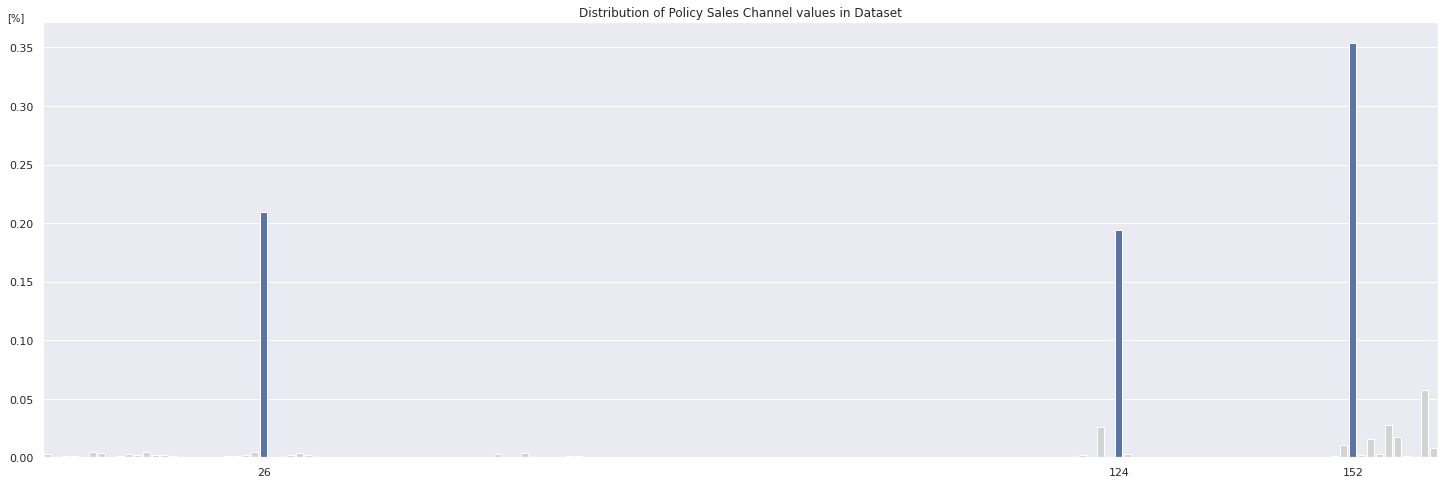

In [131]:
# gender
df_gender = df_eda['gender'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'gender': 'perc'})
df_gender['feature'] = 'gender'

# region_code
df_region_code = df_eda['region_code'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'region_code': 'perc'})
df_region_code['feature'] = 'region_code'

# policy_sales_channel
df_policy_sales_channel = df_eda['policy_sales_channel'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'policy_sales_channel': 'perc'})
df_policy_sales_channel['feature'] = 'policy_sales_channel'

# previously_insured
df_previously_insured = df_eda['previously_insured'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'previously_insured': 'perc'})
df_previously_insured['feature'] = 'previously_insured'

# driving_license
df_driving_license = df_eda['driving_license'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'driving_license': 'perc'})
df_driving_license['feature'] = 'driving_license'

# vehicle_age
df_vehicle_age = df_eda['vehicle_age'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'vehicle_age': 'perc'})
df_vehicle_age['feature'] = 'vehicle_age'

# vehicle_damage'
df_vehicle_damage = df_eda['vehicle_damage'].value_counts(normalize=True).reset_index().rename(columns={'index': 'values', 'vehicle_damage': 'perc'})
df_vehicle_damage['feature'] = 'vehicle_damage'

df_cat = pd.concat([df_gender, df_region_code, df_policy_sales_channel, df_previously_insured, 
                    df_driving_license, df_vehicle_age, df_vehicle_damage])

plt.subplot(2, 3, 1)
sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'gender']);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
plt.title('Distribution of Gender values in Dataset');

plt.subplot(2, 3, 2)
sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'previously_insured']);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
plt.title('Distribution of Previously Insured values in Dataset');

plt.subplot(2, 3, 3)
sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'driving_license']);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
plt.title('Distribution of Driving License values in Dataset');

plt.subplot(2, 3, 4)
sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'vehicle_age']);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
plt.title('Distribution of Vehicle Age values in Dataset');

plt.subplot(2, 3, 5)
sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'vehicle_damage']);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
plt.title('Distribution of Vehicle Damage values in Dataset');

plt.tight_layout()
plt.show()

perc_array = df_cat[df_cat['feature'] == 'region_code'][['values', 'perc']].sort_values('values')['perc'].to_list()
colors = ['lightgrey' if x < max(perc_array) else 'b' for x in perc_array]
sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'region_code'], palette=colors);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
plt.title('Distribution of Region Code values in Dataset')

plt.show();

aux = df_cat[df_cat['feature'] == 'policy_sales_channel'][['values', 'perc']].sort_values('values')
xticks_array = aux.apply(lambda x: '' if x['perc'] < 0.15 else x['values'], axis=1).to_list()

perc_array = aux['perc'].to_list()
colors = ['lightgrey' if x < 0.15 else 'b' for x in perc_array]

g = sns.barplot(x='values', y='perc', data=df_cat[df_cat['feature'] == 'policy_sales_channel'],palette=colors);
plt.ylabel('[%]', loc='top', labelpad=-15, fontsize=10, rotation='horizontal')
plt.xlabel('')
g.set_xticks(range(len(xticks_array)))
g.set_xticklabels(xticks_array)
plt.title('Distribution of Policy Sales Channel values in Dataset');

In [118]:
sns.color_palette(as_cmap=True)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [119]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## 4.x. Hypotheses

- 1. Older customers should be more interested in the vehicle insurance
- 2. Customers without a driving license shouldn't be interested in the vehicle insurance
- 3. Customers that got their vehicle damaged in the past should be more interested in the vehicle insurance
- 4. Customers that already have vehicle insurance shouldn't be interested in the vehicle insurance
- 5. Female customers should be more interested in the vehicle insurance